In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ipywidgets import interact, widgets
import time

In [2]:
market_cap = pd.read_excel('Group_G copy.xlsx', sheet_name=1, index_col='Date')
price_index = pd.read_excel('Group_G copy.xlsx', sheet_name=2, index_col='Date')
revenue = pd.read_excel('Group_G copy.xlsx', sheet_name=3, index_col='Date')
emission = pd.read_excel('Group_G copy.xlsx', sheet_name=4, index_col='Date')
price_index

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),ZOETIS A - TOT RETURN IND (~U$) (#T) - ZOETIS A - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T) - BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T),NASDAQ - TOT RETURN IND (~U$) (#T) - NASDAQ - TOT RETURN IND (~U$) (#T),ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T) - ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),...,WSP GLOBAL - TOT RETURN IND (~U$) (#T) - WSP GLOBAL - TOT RETURN IND (~U$) (#T),CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T) - CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T) - BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,6625.85,NaN,276.80,1874.56,153.56,NaN,NaN,4410.36,678.75,1024.69,...,NaN,NaN,4878.04,254.19,33.86,244.84,441.26,70.31,NaN,94.26
1999-01-04,6497.85,NaN,280.98,1814.45,158.25,NaN,NaN,4396.23,677.31,1041.98,...,NaN,NaN,4865.33,252.98,34.41,234.27,420.40,76.22,NaN,95.57
1999-01-05,6671.03,NaN,280.52,1795.67,154.96,NaN,NaN,4396.23,690.25,1046.91,...,NaN,NaN,4966.96,256.35,34.73,233.23,436.82,79.17,NaN,95.83
1999-01-06,6607.78,NaN,281.91,1852.02,154.55,NaN,NaN,4382.09,703.55,1045.68,...,NaN,NaN,5068.58,260.95,35.38,231.17,459.20,83.31,NaN,97.19
1999-01-07,6517.05,NaN,275.40,1852.02,153.77,NaN,NaN,4283.14,700.32,1016.05,...,NaN,NaN,4827.22,266.59,36.87,222.40,448.78,82.72,NaN,97.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,13531.69,503.29,2299.70,6271.60,768.72,364.26,1471.70,NaN,106.71,12286.12,...,2179.03,54.08,4374.88,4149.85,1465.38,1066.24,858.25,2220.63,1840.54,662.87
2022-12-27,13595.48,501.70,2236.86,6288.54,773.71,360.55,1464.50,NaN,107.37,12329.76,...,2193.17,54.96,4404.78,4176.78,1474.89,1052.60,842.91,2233.61,1852.48,667.17
2022-12-28,13474.99,496.62,2202.31,6158.66,764.53,347.95,1457.77,NaN,104.95,12164.79,...,2164.19,51.24,4379.66,4112.86,1424.19,1048.94,827.40,2203.01,1757.99,663.93


In [3]:
def assets_returns(assets, period, compounded=True):
    if not compounded:
        asset_return = (assets / assets.shift(periods=period)) - 1
    elif compounded:
        diff = assets / assets.shift(periods=period)
        asset_return = np.log(diff.astype('float'))
    return asset_return

In [4]:
simple_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=False)

In [5]:
log_return = assets_returns(price_index.loc[:, price_index.columns != 'Date'], period=1, compounded=True)

C:\Users\Hung-Chi\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [6]:
def get_moment(assetReturn, moment):
    if moment == 1:
        return pd.DataFrame(assetReturn.mean())
    elif moment == 2:
        return pd.DataFrame(assetReturn.std())
    elif moment == 3:
        return pd.DataFrame(assetReturn.skew())
    elif moment == 4:
        nu = (pow(assetReturn, moment)).mean() - pow(assetReturn.mean(), moment)
        den = pow(assetReturn.std(), moment)
        res = nu / den
        return pd.DataFrame(res)

In [7]:
simple_mean = get_moment(simple_return, 1)
simple_std = get_moment(simple_return, 2)
simple_skew = get_moment(simple_return, 3)
simple_kurt = get_moment(simple_return, 4)

In [13]:
def jarque_bera(series, skewness, kurtosis):
    t = np.shape(series)[0]
    tstat = t * (pow(skewness, 2)/6 + pow((kurtosis), 2)/24)
    return tstat

In [14]:
jb_res = jarque_bera(simple_return, simple_skew, simple_kurt)

In [15]:
def jb_test(tstat, alpha, dof):
    critical_val = stats.chi2.ppf(1-alpha, df=dof)
    out = {}
    for k, v in tstat.T.items():
        if v[0] >= critical_val:

            # print(f'Reject H0: Return is not Gaussian')
            out[k] = 'Reject H0: Return is not Gaussian'
    return pd.Series(out)

In [16]:
test_res = jb_test(jb_res, 0.05, 2)

In [17]:
def get_acf(ds: pd.DataFrame, nlags=10) -> pd.DataFrame:
    out = {}
    for k in ds.keys():
        res = sm.tsa.acf(ds[k], nlags=nlags, missing='conservative')
        out[k] = res[1:]
    return pd.DataFrame(out)

In [18]:
acf = get_acf(simple_return, nlags=10)
squared_acf = get_acf(pow(simple_return, 2), nlags=10)

C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:463: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()
C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:518: RuntimeWarning: invalid value encountered in divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
C:\Users\Hung-Chi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:463: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.sum() / notmask_int.sum()


In [19]:
def ljung_box(acf, returns, nlag):
    t = np.shape(returns)[0]
    tstat = t*(t+2)*1/(t-nlag)*pow(acf.iloc[nlag],2)
    return tstat


lj_stat = {}
for i in range(10):
    lj_stat[i] = ljung_box(acf, simple_return, i)
lj_stat = pd.DataFrame(lj_stat).transpose()

In [9]:
# Filtered portfolio inputs
opt_simple = simple_return.dropna(thresh=145).dropna(axis=1)
opt_mean = get_moment(opt_simple, 1)
opt_vol = get_moment(opt_simple, 2)
opt_skew = get_moment(opt_simple, 3)
opt_kurt = get_moment(opt_simple, 4)


# For annualized portfolio inputs
annual_mean = pow((1+opt_mean), 252) -1
annual_vol = opt_vol * np.sqrt(252)

In [10]:
def get_weight(num_assets, size):
    weights = np.random.randn(num_assets, size)
    weights = pd.DataFrame(weights)
    for i in range(size):
        weights.iloc[:, i] = weights.iloc[:, i] / weights.iloc[:, i].sum()
    return weights


# On the rows are each asset's weight in different portfolios, each column represents a randomly generated portfolio
random_weight = get_weight(np.shape(opt_simple)[1], 1000 )

In [11]:
def portfolio_return(asset_returns, port_weight):
    if np.shape(asset_returns)[1] != np.shape(port_weight)[0]:
        port_mean = asset_returns.T.values @ port_weight.values
    else:
        port_mean = asset_returns.values @ port_weight.values
    port_mean = pd.DataFrame(port_mean).transpose()
    port_mean.index = port_weight.T.index
    port_mean.columns = ['Portfolio Mean']
    return port_mean


def vcv_matrix(asset_returns):
    return asset_returns.cov()


def portfolio_var(port_weight, vcv):
    out = {}
    for i in port_weight:
        out[i] = port_weight.iloc[:, i].values.T @ vcv.values @ port_weight.iloc[:, i].values
    out = pd.Series(out)
    out.name = 'Sigma'
    return out

In [15]:
opt_mu = portfolio_return(opt_mean, random_weight)
opt_vcv = vcv_matrix(opt_simple)
opt_sigma2 = portfolio_var(random_weight, opt_vcv)
opt_sigma = np.sqrt(opt_sigma2)
annual_opt_mu = pow((1+opt_mu), 252) -1
annual_opt_vol = opt_sigma * np.sqrt(252)

# Efficient frontier

### Sort monthly data

In [8]:
# monthly return
r = simple_return.dropna(axis=1, thresh=6250)  # drop nan with a threshold
monthly_df = r.resample('M').agg(lambda x: (x + 1).prod() - 1)  # merge daily to monthly
price_df = price_index.dropna(axis=1, thresh=6250).resample('M').mean()  # monthly price
price_df.columns = [i.split('-')[0] for i in price_df.columns]
monthly_df.head(5)

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T) - RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T),SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T) - SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T),NETAPP - TOT RETURN IND (~U$) (#T) - NETAPP - TOT RETURN IND (~U$) (#T),COPART - TOT RETURN IND (~U$) (#T) - COPART - TOT RETURN IND (~U$) (#T),...,STATE STREET - TOT RETURN IND (~U$) (#T) - STATE STREET - TOT RETURN IND (~U$) (#T),RAYONIER - TOT RETURN IND (~U$) (#T) - RAYONIER - TOT RETURN IND (~U$) (#T),S&P GLOBAL - TOT RETURN IND (~U$) (#T) - S&P GLOBAL - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-31,-0.143076,-0.001698,0.058115,-0.058479,0.050843,-0.137349,0.098276,-5.551115e-16,0.181886,-0.042463,...,0.019608,-0.042204,0.061350,0.036457,-0.007239,0.101595,-0.232846,0.075103,0.258427,0.040738
1999-02-28,-0.143808,0.070206,0.121210,0.022341,-0.109876,-0.092177,0.040220,-3.147608e-02,-0.207552,0.129028,...,0.072552,-0.069571,0.016024,-0.042713,0.003408,-0.110724,-0.098919,-0.164418,-0.123305,0.017227
1999-03-31,0.012441,-0.073479,0.071981,0.159461,-0.029328,0.064613,0.093340,-1.441489e-01,0.205354,0.185693,...,0.074364,-0.013874,-0.003998,-0.135419,0.024841,0.155864,0.158523,0.176211,-0.007735,0.044994
1999-04-30,0.007188,0.105182,0.196200,0.041253,0.100703,0.197982,0.069682,2.051753e-01,-0.006165,-0.126515,...,0.063830,0.138866,0.013761,0.079269,0.005934,0.285342,0.178958,-0.052118,0.154346,0.055428
1999-05-31,0.085889,0.064527,0.096562,-0.043654,-0.043607,-0.037393,-0.141110,6.924152e-02,-0.062737,0.006899,...,-0.128571,0.021916,-0.057378,-0.090397,-0.049073,-0.173093,-0.013410,0.060029,0.003489,-0.023169


In [9]:
def efficient_frontier(mean, vcv, risk_aversion, num_port):
    """

    :param mean: All asset's expected return
    :param vcv: The variance covariance matrix
    :param risk_aversion: Investor's risk aversion
    :param num_port: Number of equally spaced return portfolios we want display on the efficient frontier
    
    :return: This function returns a list of objects.
        frontier: The mean variance efficient frontier with x number of MVP portfolios
        gmvp_weight: The asset allocation of the global minimum variance portfolio
        gmvp_mean: The mean of the global minimum variance portfolio
        gmvp_variance: The variance of the global minimum variance portfolio
        optimal_weight: The asset allocation of the optimal portfolio
        optimal_mean: The mean of the optimal portfolio
        optimal_variance: The variance of the optimal portfolio
    """

    e = np.ones(np.shape(mean)[0])
    vcv_inv = np.linalg.inv(vcv)
    A = mean.T @ vcv_inv @ mean
    B = e.T @ vcv_inv @ mean
    C = e.T @ vcv_inv @ e
    alpha_spec = (e.T @ vcv_inv @ mean) / risk_aversion
    alpha_min = 1-alpha_spec

    # The mean-variance efficient frontier
    mu = np.linspace(-0.1, 1, num_port)
    std = ((C * pow(mu, 2) - 2*B*mu + A)/(A*C-pow(B, 2))).T.reshape(-1)
    frontier = pd.DataFrame({'mu_p': mu, 'mu_std': std})

    # The global mean variance portfolio
    gmvp_weight = vcv_inv @ e / C
    gmvp_mean = gmvp_weight.T @ mean
    gmvp_variance = gmvp_weight.T @ vcv @ gmvp_weight

    # The speculative portfolio
    spec_weight = vcv_inv @ mean / (e.T @ vcv_inv @ mean)
    spec_mean = spec_weight.T @ mean
    spec_variance = spec_weight.T @ vcv @ spec_weight

    # The optimal portfolio
    optimal_weight = alpha_min * gmvp_weight.reshape(-1) + alpha_spec * spec_weight.reshape(-1)
    optimal_mean = optimal_weight.T @ mean
    optimal_variance = optimal_weight.T @ vcv @ optimal_weight

    return frontier, gmvp_weight, gmvp_mean, gmvp_variance, optimal_weight, optimal_mean, optimal_variance

In [10]:
r = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=2, num_port=100)
r[0]

NameError: name 'opt_mean' is not defined

In [812]:
@interact()
def plot(risk_aversion=widgets.FloatSlider(min=0, max=10, step=0.1, value=1)):

    f = efficient_frontier(opt_mean.values, opt_vcv, risk_aversion=risk_aversion, num_port=100)

    ax = plt.gca()
    ax.plot(f[0]['mu_std'], f[0]['mu_p'])
    gmvp_weight = f[1]
    gmvp_retr = f[2]
    gmvp_vcv = f[3]

    optimal_variance = f[-1]
    optimal_mu = f[-2]

    ax.plot(gmvp_vcv, gmvp_retr, 'ro')
    ax.plot(optimal_variance, optimal_mu, 'bo')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
    ax.axhline(y=0,color='k', ls='-')
    ax.set_ylim(-0.1, 0.6)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Var')
    ax.set_ylabel('Return')

interactive(children=(FloatSlider(value=1.0, description='risk_aversion', max=10.0), Output()), _dom_classes=(…

In [49]:
# Efficient frontier using optimization method
def min_variance_portfolio(mean, vcv, initial_weight):
    """

    :param vcv: The variance covariance matrix
    :param initial_weight: Initial guess of asset weight allocation
    :param risk_free:
    
    :return: Returns a list of objects.
    1. Optimal weight allocation of assets given the covariance matrix
    2. The return of this global minimum variance portfolio
    3. The variance of this global minimum variance portfolio
    """
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
    }
    bnds = [[None, None] for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, constraints=cons, bounds=bnds)
    r = port_weight.x.reshape(1, -1)
    port_mean = r @ mean
    port_vcv = np.sqrt(r @ vcv @ r.T)
    return [port_weight, port_mean, port_vcv]

In [51]:
pweight = min_variance_portfolio(opt_mean, opt_vcv, r[1])
gmvp_weight = pweight[0]
gmvp_mean = pweight[1]
gmvp_variance = pweight[2]
gmvp_mean

,0
0,0.000407


In [52]:
def optimal_portfolio(mean, vcv, initial_weight, risk_free):
    vcv_inv = np.linalg.inv(vcv)
    ones = np.ones(np.shape(mean))
    
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun' : lambda a: a.T @ mean + (1 - ones.T @ a) * risk_free - a.T @ mean
    }
    bnds = [(None, None) for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, method='SLSQP', constraints=cons, bounds=bnds)
    a_str = port_weight.x.reshape(-1, 1)
#     optimal_portfolio = port_weight.x.reshape(1, -1)
#     port_mean = optimal_portfolio @ mean
    
    excess_mu = mean - risk_free * ones
#     tan_port = (vcv_inv @ excess_mu) / (ones.T @ vcv_inv @ excess_mu)
    tan_port = a_str / (ones.T @ a_str)
    tan_mu = tan_port.T @ excess_mu + risk_free
    tan_vcv = tan_port.T @ vcv @ tan_port
#     return [port_weight.x, optimal_portfolio, port_mean, tan_port, tan_mu, tan_vcv]
    
    return tan_port, tan_mu, tan_vcv


# res = optimal_portfolio(opt_mean.values, opt_vcv, minport, 0.005)
# res[-2]


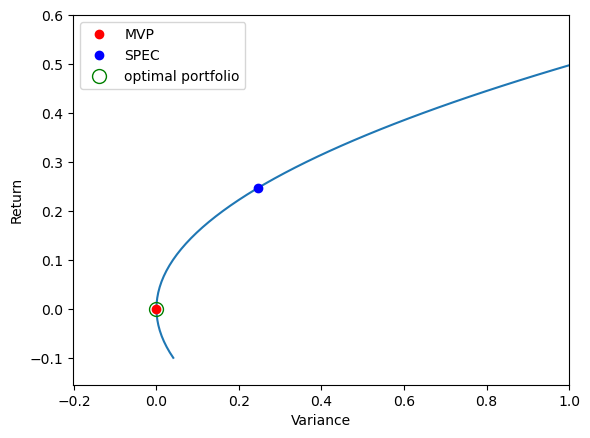

In [53]:
# daily

f = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=1, num_port=100)

ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
gmvp_weight = f[1]
gmvp_retr = f[2]
gmvp_vcv = f[3]

optimal_variance = f[-1]
optimal_mu = f[-2]

ax.plot(gmvp_vcv, gmvp_retr, 'ro', label='MVP')
ax.plot(optimal_variance, optimal_mu, 'bo', label='SPEC')


res = optimal_portfolio(opt_mean.values, opt_vcv.values, f[1], 0.05)
ax.plot(res[-1], res[-2], 'go', ms=10, mfc='none', label='optimal portfolio')
ax.set_xlabel('Variance')
ax.set_ylabel('Return')
ax.set_xlim(None, 1)
ax.set_ylim(None, 0.6)
ax.legend()

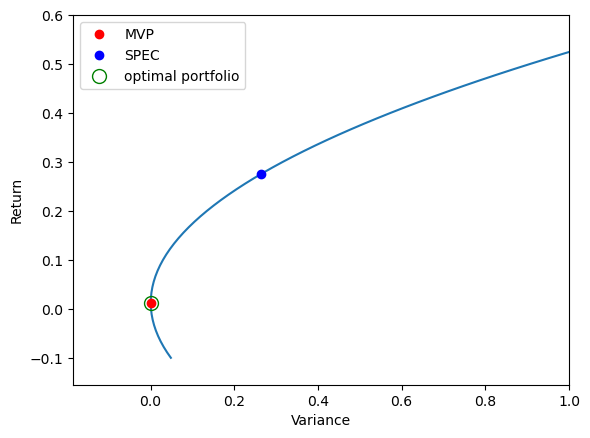

In [54]:
# monthly


f = efficient_frontier(monthly_df.mean().values, monthly_df.cov().values, risk_aversion=1, num_port=100)

ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
gmvp_weight = f[1]
gmvp_retr = f[2]
gmvp_vcv = f[3]

optimal_variance = f[-1]
optimal_mu = f[-2]

ax.plot(gmvp_vcv, gmvp_retr, 'ro', label='MVP')
ax.plot(optimal_variance, optimal_mu, 'bo', label='SPEC')


res = optimal_portfolio(monthly_df.mean().values, monthly_df.cov().values, f[1], 0.05)
ax.plot(res[-1], res[-2], 'go', ms=10, mfc='none', label='optimal portfolio')
ax.set_xlabel('Variance')
ax.set_ylabel('Return')
ax.set_xlim(None, 1)
ax.set_ylim(None, 0.6)
ax.legend()

In [40]:
mvp_mean = np.mean(mvp_weight_monthly.T * monthly_df, axis=1)
mvp_price = np.mean(mvp_weight_monthly.T * price_df, axis=1)
mvp_char = cal_char(pd.DataFrame(mvp_mean), mvp_price)
pd.DataFrame(mvp_char._asdict(), index=['mvp'])

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
mvp,0.001648,0.000837,-0.000622,0.000771,-1.078036,-0.000268,-0.000374


# Resampling function

In [18]:
def portfolio_resampling(Q, m, p0, risk_aversion=2, num_port=201):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
    ax = plt.gca()

    p0_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
        p0.mean(), p0.cov(), risk_aversion=risk_aversion, num_port=num_port)
    ax.plot(p0_ft.mu_std, p0_ft.mu_p, 'k--', label='p0')
    print('P0 data, min_mu / max_mu', min_mu, max_mu)

    mu_0 = p0.mean()
    cov_0 = p0.cov()

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    for i in range(Q):
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=p0.shape)
        p1 = pd.DataFrame(p1)
        p1_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
            p1.mean(), p1.cov(), risk_aversion=risk_aversion, num_port=num_port)
        
        mu_1 = p1.mean()
        cov_1 = p1.cov()
        c = 0
        for mu in np.linspace(min_mu, max_mu, m):
            obj = lambda a: a.T @ cov_1 @ a
            cons1 = {
                'type': 'eq',
                'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
            }
            cons2 = {
                'type': 'eq',
                'fun': lambda a: a.T @ mu_1 - mu
            }
            w0 = np.random.random(mu_1.shape)
            w0 /= w0.sum()
            bnds = [[None, None] for i in range(len(w0))]
            res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
            r = res.x
            opt_mu = r.T @ mu_0
            opt_cov = r.T @ cov_0 @ r
            ax.plot(opt_cov, opt_mu, 'bo')
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(r)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)
        
    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)
    
    
    ax.plot(cov_res, mu_res, 'r-', label='resampled', ms=3)
    ax.legend()
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.1, 1)
    
    return p0_ft, mu_res, cov_res, ares, opt_mus, opt_covs

In [19]:
def get_ABCD(mu, cov):
    e = np.ones(len(mu))
    _A = e.T @  inv(cov) @ mu
    _B = mu.T @ inv(cov) @ mu
    _C = e.T @ inv(cov) @ e
    _D = _B*_C - _A**2
    return _A, _B, _C, _D

def get_MVP(mu, cov):
    _, _, _C, _ = get_ABCD(mu, cov)
    alpha_min = inv(cov) @ e / _C
    mu_min = alpha_min.T @ mu
    cov_min = alpha_min.T @ cov @ alpha_min
    return alpha_min, mu_min, cov_min

def get_SPEC(mu, cov):
    _A, _, _, _ = get_ABCD(mu, cov)
    alpha_spec = inv(cov) @ mu / _A
    mu_spec = alpha_spec.T @ mu
    cov_spec = alpha_spec.T @ cov @ alpha_spec
    return alpha_spec, mu_spec, cov_spec

def get_maxsharpe(mu, cov, risk_aversion=2):
    e = np.ones(len(mu))
    alpha_mvp, mu_mvp, cov_mvp = get_MVP(mu, cov)
    alpha_spec, mu_spec, cov_spec = get_SPEC(mu, cov)

    ratio_spec = (e.T @ inv(cov) @ mu) / risk_aversion
    ratio_mvp = 1 - ratio_spec

    optimal_weight = ratio_mvp * alpha_mvp + ratio_spec * alpha_spec
    optimal_mu = optimal_weight.T @ mu
    optimal_cov = optimal_weight.T @ cov @ optimal_weight
    return optimal_weight, optimal_mu, optimal_cov

def get_FT_func(mu, cov):
    _A, _, _C, _D = get_ABCD(mu, cov)
    return lambda x: (x - _A/_C)**2 * _C / _D + 1/_C

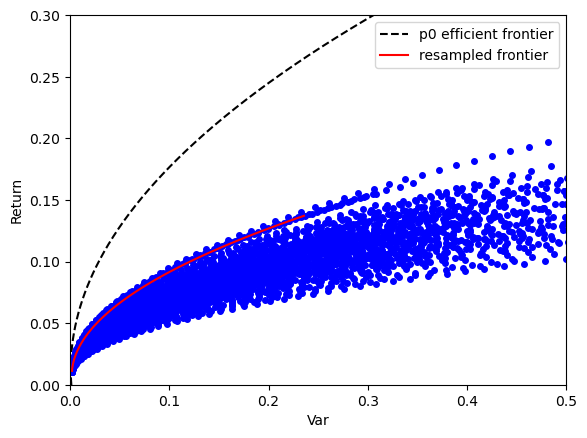

In [804]:
Q=100
m=50
p0=monthly_df.iloc[:-1]
risk_aversion=2

ax = plt.gca()

mu_0 = p0.mean()
cov_0 = p0.cov()
func = get_FT_func(mu_0, cov_0)
dummy_mu = np.linspace(-0.1, 0.8, 1001)
ax.plot(func(dummy_mu), dummy_mu, 'k--', label='p0 efficient frontier')

opt_mus = []
opt_covs = []
a_res = [[] for i in range(m)]
e = np.ones(len(mu_0))

for i in range(Q):
    p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values,
                          size=p0.shape
                         )
    p1 = pd.DataFrame(p1)
    mu_1 = p1.mean()
    cov_1 = p1.cov()

    _A, _B, _C, _D = get_ABCD(mu_1, cov_1)

    V1 = inv(cov_1)/_D @ (_B*e - _A*mu_1) 
    V2 = inv(cov_1)/_D @ (_C*mu_1 - _A*e)

    _, mu_mvp, _ = get_MVP(mu_1, cov_1)
    _, mu_ms, _ = get_maxsharpe(mu_1, cov_1, risk_aversion)
    
    c = 0
    for mu in np.linspace(mu_mvp, mu_ms, m):
        alpha_star = V1 + V2 * mu

        opt_mu = alpha_star.T @ mu_0
        opt_cov = alpha_star.T @ cov_0 @ alpha_star
        ax.plot(opt_cov, opt_mu, 'bo', ms=4)
        opt_mus.append(opt_mu)
        opt_covs.append(opt_cov)
        a_res[c].append(alpha_star)
        c += 1

mu_res = []
cov_res = []
ares = []
for i in range(m):
    _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
    mu_res.append(_a_res.T @ mu_0)
    cov_res.append(_a_res.T @ cov_0 @ _a_res)
    ares.append(_a_res)

mu_res = np.array(mu_res)
cov_res = np.array(cov_res)
ares = np.array(ares)

ax.plot(cov_res.reshape(-1), mu_res.reshape(-1), 'r-', label='resampled frontier')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.legend()

In [476]:
def portfolio_resampling_ABCD(Q, m, p0, risk_aversion=2, num_port=201, p1_num=None):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
#     ax = plt.gca()

    mu_0 = p0.mean()
    cov_0 = p0.cov()
#     func = get_FT_func(mu_0, cov_0)
#     dummy_mu = np.linspace(-0.1, 0.8, 1001)
#     ax.plot(func(dummy_mu), dummy_mu, 'k--', label='p0')

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    e = np.ones(len(mu_0))

    for i in range(Q):
        size = p0.shape
        if p1_num is not None:
            _, col = size
            size = (p1_num, col)
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values,
                              size=size)
        p1 = pd.DataFrame(p1)
        mu_1 = p1.mean()
        cov_1 = p1.cov()

        _A, _B, _C, _D = get_ABCD(mu_1, cov_1)

        V1 = inv(cov_1)/_D @ (_B*e - _A*mu_1) 
        V2 = inv(cov_1)/_D @ (_C*mu_1 - _A*e)

        _, mu_mvp, _ = get_MVP(mu_1, cov_1)
        _, mu_ms, _ = get_maxsharpe(mu_1, cov_1, risk_aversion)


        c = 0
        for mu in np.linspace(mu_mvp, mu_ms, m):
            alpha_star = V1 + V2 * mu

            opt_mu = alpha_star.T @ mu_0
            opt_cov = alpha_star.T @ cov_0 @ alpha_star
#             ax.plot(opt_cov, opt_mu, 'bo')
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(alpha_star)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)

    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)

#     ax.plot(cov_res.reshape(-1), mu_res.reshape(-1), 'r-')
    return mu_res, cov_res, ares, opt_mus, opt_covs

In [ ]:
def save_results(mu_res, cov_res, ares, filename):
    index_name = ...s
    mu_res = pd.DataFrame(mu_res, index=index_name)
    cov_res = pd.DataFrame(cov_res, index=index_name)
    ares = pd.DataFrame(ares, index=index_name)
    
    mu_res.to_csv(f'{filename}_mu.csv')
    cov_res.to_csv(f'{filename}_cov.csv')
    ares_res.to_csv(f'{filename}_ares.csv')

(-0.1, 0.5)

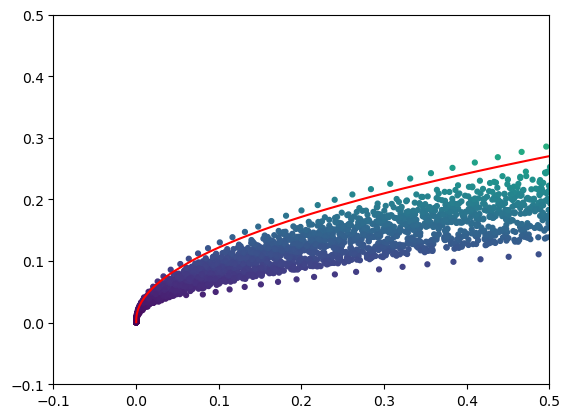

In [34]:
ax = plt.gca()

ax.plot(cov_res, mu_res, 'r-')
ax.scatter(opt_covs, opt_mus, c=np.asarray(opt_mus), s=12)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)

In [ ]:
# In sample MVP portfolios 

In [60]:
resampled_mu = pd.read_csv('mu_res.csv')
resampled_vcv = pd.read_csv('cov_res.csv')
resampled_weight = pd.read_csv('a_res.csv')
resampled_opt_mu = pd.read_csv('opt_mus.csv')
resampled_opt_vcv = pd.read_csv('opt_covs.csv')

In [61]:
#Average Annualized MVP Return
Expectation_MVP = resampled_mu.iloc[0]
Expectation_MVP = Expectation_MVP.drop(Expectation_MVP.index[0])
Expectation_MVP = Expectation_MVP.to_numpy()
A_Expectation_MVP = Expectation_MVP*252
A_Expectation_MVP

array([0.08458431])

In [62]:
#Annualized volatility of the MVP
Variance_MVP = resampled_vcv.iloc[0]
Std_MVP = np.sqrt(Variance_MVP)
A_Std_MVP = Std_MVP * np.sqrt(252)
A_Std_MVP

Unnamed: 0    0.000000
0             0.178418
Name: 0, dtype: float64

In [63]:
#MVP Weights
Weights_MVP = resampled_weight.iloc[0]
Weights_MVP = Weights_MVP.drop(Weights_MVP.index[0])
Weights_MVP = Weights_MVP.to_numpy()

#Minimum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.min(Returns_daily_MVP)
Min_Returns_Daily_MVP

-0.038875761676071305

In [64]:
#Maximum daily return of the MVP
Returns_daily_MVP = np.matmul(opt_simple,Weights_MVP)
Min_Returns_Daily_MVP = np.max(Returns_daily_MVP)
Min_Returns_Daily_MVP

0.031223300379483083

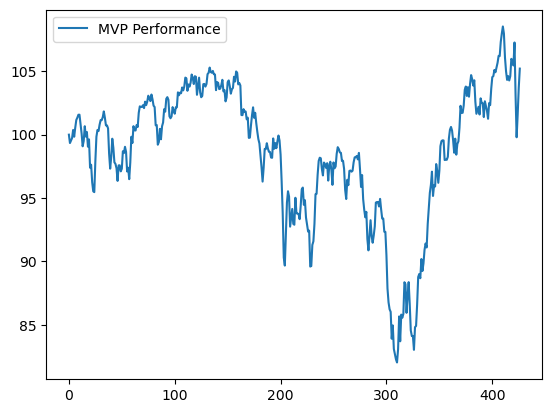

In [65]:
#MVP performance
portfolio_values_MVP = [100]
for ret in Returns_daily_MVP:
    portfolio_values_MVP.append(portfolio_values_MVP[-1]*(1+ret))

plt.plot(portfolio_values_MVP)
plt.legend(['MVP Performance'])
plt.show()

In [66]:
#Maximum Drawdown MVP
pd_portfolio_values_MVP = pd.Series(portfolio_values_MVP)
max_data_stock = pd_portfolio_values_MVP.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).max()
dd_stock = pd_portfolio_values_MVP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_MVP), min_periods=1).min()
MDD_stock.min()

-0.2209539707116117

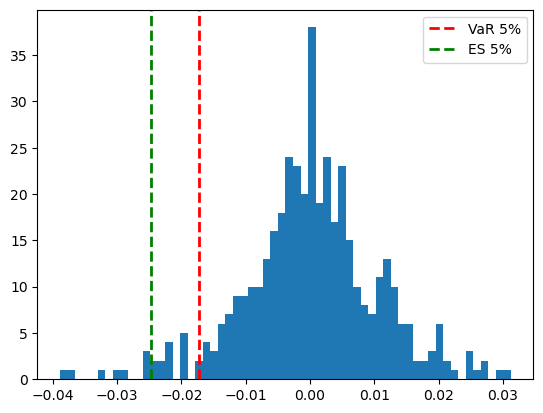

In [67]:
#VaR and ES at 5% of the MVP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_MVP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_MVP[Returns_daily_MVP<=quantile])

plt.hist(Returns_daily_MVP, 60)
VaR_95_MVP = np.percentile(Returns_daily_MVP, 5)
plt.axvline(x=VaR_95_MVP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [68]:
print("Value at Risk 5%:", VaR_95_MVP)
print("Expected Shortfall: ", expected_shortfall)

Value at Risk 5%: -0.01734108108874695
Expected Shortfall:  -0.024698360949904838


In [69]:
# Equally weighted portfolio

In [70]:
#Average Annualized MVP Return
Weights_EWP = [1/len(opt_mean)]*len(opt_mean)
Weights_EWP = np.array(Weights_EWP)
Weights_EWP_T = np.transpose(Weights_EWP)
Return_EWP = np.matmul(Weights_EWP_T,opt_mean)
A_Return_EWP = Return_EWP*252
A_Return_EWP

0    0.038196
dtype: float64

In [71]:
#Annualized volatility of the EWP
Variance_EWP = np.matmul(Weights_EWP_T,np.matmul(opt_vcv,Weights_EWP))
Std_EWP = np.sqrt(Variance_EWP)
A_Std_EWP = Std_EWP * np.sqrt(252)
A_Std_EWP

0.16693682480661376

In [72]:
#Minimum daily return of the EWP
Returns_daily_EWP = np.matmul(opt_simple,Weights_EWP)
Min_Returns_Daily_EWP = np.min(Returns_daily_EWP)
Min_Returns_Daily_EWP

-0.0388103224779409

In [73]:
#Maximum daily return of the MVP
Max_Returns_Daily_EWP = np.max(Returns_daily_EWP)
Max_Returns_Daily_EWP

0.03154269077077159

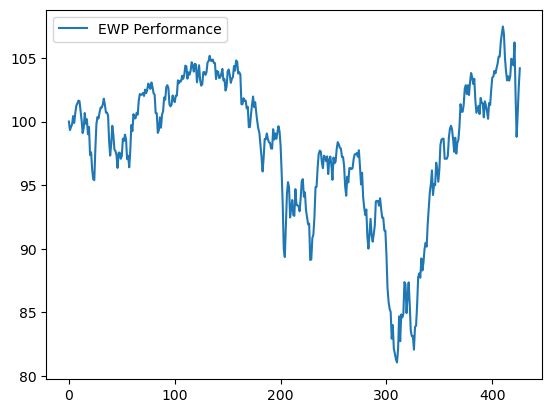

In [74]:
#EWP Performance
portfolio_values_EWP = [100]
for ret in Returns_daily_EWP:
    portfolio_values_EWP.append(portfolio_values_EWP[-1]*(1+ret))

plt.plot(portfolio_values_EWP)
plt.legend(['EWP Performance'])
plt.show()

In [75]:
#Maximum Drawdown EWP
pd_portfolio_values_EWP = pd.Series(portfolio_values_EWP)
max_data_stock = pd_portfolio_values_EWP.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).max()
dd_stock = pd_portfolio_values_EWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_EWP), min_periods=1).min()
MDD_stock.min()

-0.2293232935742623

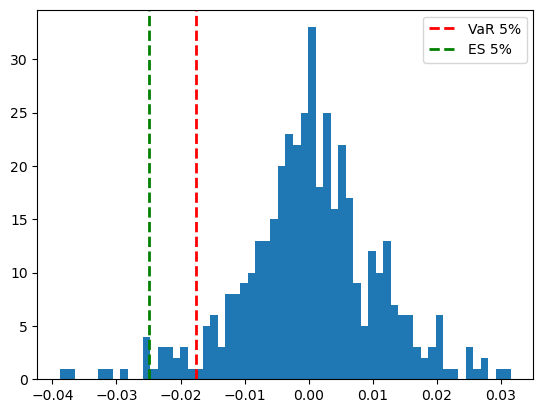

In [76]:
#VaR and ES at 5% of the EWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_EWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_EWP[Returns_daily_EWP<=quantile])

plt.hist(Returns_daily_EWP, 60)
VaR_95_EWP = np.percentile(Returns_daily_EWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [77]:
print("Value at Risk 5%:", VaR_95_EWP)
print("Expected Shortfall: ", expected_shortfall)

Value at Risk 5%: -0.017524436796305227
Expected Shortfall:  -0.024880033317407492


In [78]:
# Value weighted portfolio 

In [79]:
#Average Annualized VWP Return
market_cap['day'] = market_cap['Date'].dt.day
last_day_of_month = market_cap[market_cap['day'] == market_cap.groupby(market_cap['Date'].dt.month)['day'].transform('max')]
last_day_of_month = last_day_of_month.drop(columns=['Date', '#ERROR', '#ERROR.1', 'DENBURY - MARKET VALUE', 'EXCO RES - MARKET VALUE', 'day'])
opt_market = last_day_of_month.dropna(thresh=145).dropna(axis=1)
sum_list = opt_market.sum(axis=0)
Weights_VWP = [v / sum(sum_list) for v in sum_list]
Weights_VWP_T = np.transpose(Weights_VWP)
Return_VWP = np.matmul(Weights_VWP_T,opt_mean)
A_Return_VWP = Return_VWP*252
A_Return_VWP

0    0.120007
dtype: float64

In [80]:
#Annualized volatility of the VWP
Variance_VWP = np.matmul(Weights_VWP_T,np.matmul(opt_vcv,Weights_VWP))
Std_VWP = np.sqrt(Variance_VWP)
A_Std_VWP = Std_VWP * np.sqrt(252)
A_Std_VWP

0.1533484527007096

In [81]:
#Minimum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Min_Returns_Daily_VWP = np.min(Returns_daily_VWP)
Min_Returns_Daily_VWP

-0.03945662286412157

In [82]:
#Maximum daily return of the VWP
Returns_daily_VWP = np.matmul(opt_simple,Weights_VWP)
Max_Returns_Daily_VWP = np.max(Returns_daily_VWP)
Max_Returns_Daily_VWP

0.03602601448774442

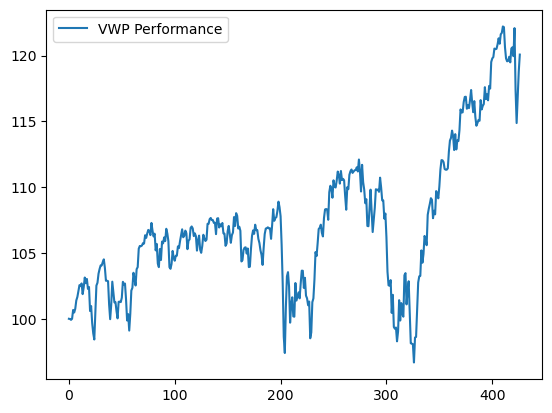

In [83]:
#VWP Performance
portfolio_values_VWP = [100]
for ret in Returns_daily_VWP:
    portfolio_values_VWP.append(portfolio_values_VWP[-1]*(1+ret))

plt.plot(portfolio_values_VWP)
plt.legend(['VWP Performance'])
plt.show()

In [84]:
#Maximum Drawdown VWP
pd_portfolio_values_VWP = pd.Series(portfolio_values_VWP)
max_data_stock = pd_portfolio_values_VWP.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).max()
dd_stock = pd_portfolio_values_VWP/max_data_stock - 1
MDD_stock = dd_stock.rolling(window=len(pd_portfolio_values_VWP), min_periods=1).min()
MDD_stock.min()

-0.1375934472581699

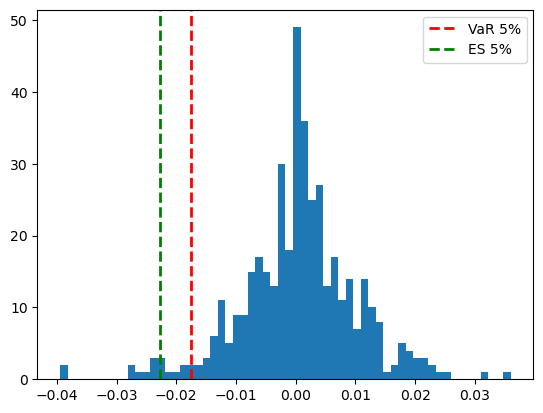

In [85]:
#VaR and ES at 5% of the VWP
quantile_threshold = 0.05

quantile = np.quantile(Returns_daily_VWP, quantile_threshold)

expected_shortfall = np.mean(Returns_daily_VWP[Returns_daily_VWP<=quantile])

plt.hist(Returns_daily_VWP, 60)
VaR_95_VWP = np.percentile(Returns_daily_VWP, 5)
plt.axvline(x=VaR_95_EWP, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=expected_shortfall, color='g', linestyle='dashed', linewidth=2)
plt.legend(['VaR 5%','ES 5%'])
plt.show()

In [86]:
print("Value at Risk 5%:", VaR_95_VWP)
print("Expected Shortfall: ", expected_shortfall)

Value at Risk 5%: -0.014865485005395678
Expected Shortfall:  -0.02276173444256211


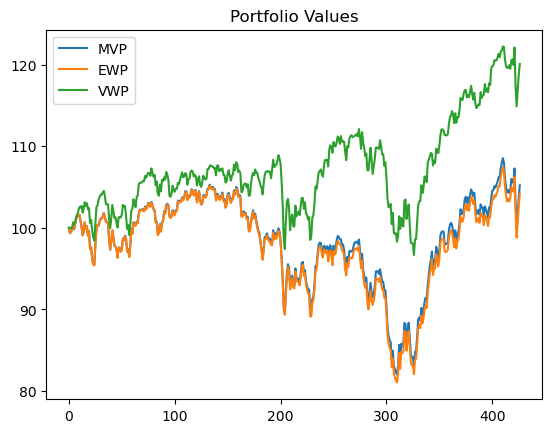

In [87]:
#Graph of the performance of the 3 portfolios

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(portfolio_values_MVP, label='MVP')
ax.plot(portfolio_values_EWP, label='EWP')
ax.plot(portfolio_values_VWP, label='VWP')

ax.set_title('Portfolio Values')
ax.legend()

plt.show()

# 1.5: 6-year moving window

## Structure the monthly data

In [100]:
# monthly return
r = simple_return.dropna(axis=1, thresh=6250)  # drop nan with a threshold
monthly_df = r.resample('M').agg(lambda x: (x + 1).prod() - 1)  # merge daily to monthly
monthly_vol = r.resample('M').std()  # monthly volatility
price_df = price_index.dropna(axis=1, thresh=6250).resample('M').mean()  # monthly price
monthly_df.head(5)

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T) - RAYTHEON TECHNOLOGIES - TOT RETURN IND (~U$) (#T),SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T) - SCHNITZER STL.INDS. - TOT RETURN IND (~U$) (#T),NETAPP - TOT RETURN IND (~U$) (#T) - NETAPP - TOT RETURN IND (~U$) (#T),COPART - TOT RETURN IND (~U$) (#T) - COPART - TOT RETURN IND (~U$) (#T),...,STATE STREET - TOT RETURN IND (~U$) (#T) - STATE STREET - TOT RETURN IND (~U$) (#T),RAYONIER - TOT RETURN IND (~U$) (#T) - RAYONIER - TOT RETURN IND (~U$) (#T),S&P GLOBAL - TOT RETURN IND (~U$) (#T) - S&P GLOBAL - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-31,-0.143076,-0.001698,0.058115,-0.058479,0.050843,-0.137349,0.098276,-5.551115e-16,0.181886,-0.042463,...,0.019608,-0.042204,0.061350,0.036457,-0.007239,0.101595,-0.232846,0.075103,0.258427,0.040738
1999-02-28,-0.143808,0.070206,0.121210,0.022341,-0.109876,-0.092177,0.040220,-3.147608e-02,-0.207552,0.129028,...,0.072552,-0.069571,0.016024,-0.042713,0.003408,-0.110724,-0.098919,-0.164418,-0.123305,0.017227
1999-03-31,0.012441,-0.073479,0.071981,0.159461,-0.029328,0.064613,0.093340,-1.441489e-01,0.205354,0.185693,...,0.074364,-0.013874,-0.003998,-0.135419,0.024841,0.155864,0.158523,0.176211,-0.007735,0.044994
1999-04-30,0.007188,0.105182,0.196200,0.041253,0.100703,0.197982,0.069682,2.051753e-01,-0.006165,-0.126515,...,0.063830,0.138866,0.013761,0.079269,0.005934,0.285342,0.178958,-0.052118,0.154346,0.055428
1999-05-31,0.085889,0.064527,0.096562,-0.043654,-0.043607,-0.037393,-0.141110,6.924152e-02,-0.062737,0.006899,...,-0.128571,0.021916,-0.057378,-0.090397,-0.049073,-0.173093,-0.013410,0.060029,0.003489,-0.023169


In [11]:
# market cap

cols = []
for col in monthly_df.columns:
    col = col.split('-')
    for mkt_col in market_cap.columns:
        if mkt_col.startswith(col[0]):
            cols.append(mkt_col)
market_cap = market_cap.loc[:, market_cap.columns.isin(cols)] 
market_cap.index = r.index
market_cap = market_cap.resample('M').mean()

## Portfolio using moving window

In [ ]:
win_len = 72  # 6-year moving window
Q = 100  # number of Monte Carlo simulation
m = 2 # number of mean points durung the resampling, here is two for min mean and max mean.
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 0  # loop index

# --- results --- #
min_mu = []
max_mu = []

min_var = []
max_var = []

min_p = []
max_p = []
# --------------- #

while running:
    print(f'Progress: {c}/217 ...')
    
    # generate moving window
    start = c
    stop = c + win_len-1
    mov = monthly_df.iloc[slice(start, stop), :]
    
    # resampling
    mu_res, cov_res, ares, _, _ = portfolio_resampling_ABCD(Q=Q, m=m, p0=mov, p1_num=p1_num)
    min_mu.append(mu_res[0])
    max_mu.append(mu_res[-1])
    
    min_var.append(cov_res[0])
    max_var.append(cov_res[-1])
    
    min_p.append(ares[0])
    max_p.append(ares[-1])
    
    c += 1
    if stop == len(monthly_df):
        running = False


# Convert to DataFrame        
min_mu = pd.DataFrame(min_mu, index=monthly_df[monthly_df.index > '2005'].index)
max_mu = pd.DataFrame(max_mu, index=monthly_df[monthly_df.index > '2005'].index)

min_var = pd.DataFrame(min_var, index=monthly_df[monthly_df.index > '2005'].index)
max_var = pd.DataFrame(max_var, index=monthly_df[monthly_df.index > '2005'].index)

min_p = pd.DataFrame(min_p, index=monthly_df[monthly_df.index > '2005'].index)
max_p = pd.DataFrame(max_p, index=monthly_df[monthly_df.index > '2005'].index)

## Performance of the moving window methodology

In [558]:
# mean
res = [[], []]
for i in range(18*12):
    ret = min_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[0].append(ret)
    ret = max_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[1].append(ret)

# convert to DataFrame
port_min_mu = pd.DataFrame(res[0], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_min_mu'])
# port_min_mu.to_csv('monving_window_performance_min_mu_strategy.csv')
port_max_mu = pd.DataFrame(res[1], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_max_mu'])
# port_max_mu.to_csv('monving_window_performance_max_mu_strategy.csv')


In [12]:
from collections import namedtuple
Char = namedtuple('Char',
    'annualized_average_return annualized_volatility minimal maximal max_drawdown VaR ES')
def cal_char(returns, price):
    return Char(
        annualized_average_return=(returns.mean()*12)[0],
        annualized_volatility=(np.sqrt(returns.cov()*12)).values[0][0],
        minimal=returns.min()[0],
        maximal=returns.max()[0],
        max_drawdown=(np.min(price)/ np.max(price) - 1),
        VaR=returns.quantile(0.05)[0],
        ES=returns[returns < returns.quantile(0.05)].mean()[0]
        )

In [13]:
# characteristics
port_min_mu = pd.read_csv('1.5_monving_window_performance_min_mu_strategy.csv', index_col=0)
port_max_mu = pd.read_csv('1.5_monving_window_performance_max_mu_strategy.csv', index_col=0)
min_p = pd.read_csv('1.5_moving_windown_min_p.csv', index_col=0)
max_p = pd.read_csv('1.5_moving_windown_max_p.csv', index_col=0)

price_min_p = np.sum(min_p.values * price_df[price_df.index >= '2005'].values, axis=1)
price_max_p = np.sum(max_p.values * price_df[price_df.index >= '2005'].values, axis=1)


port_min_mu_char = cal_char(port_min_mu, price_min_p)
port_max_mu_char = cal_char(port_max_mu, price_max_p)
dfs = [pd.DataFrame(port_min_mu_char._asdict(), index=['moving_window_min_mu']), 
       pd.DataFrame(port_max_mu_char._asdict(), index=['moving_window_max_mu'])]
dfs = pd.concat(dfs)
dfs

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-0.875999,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.181835,-2.772540,-4.709701


## Comparison

In [14]:
# other weights
equal_weights = np.ones(len(monthly_df.columns)) / len(monthly_df.columns)
mkt_weights = market_cap[market_cap.index > '2005'].div(
    market_cap[market_cap.index > '2005'].sum(axis=1), axis=0)

In [15]:
# equal
port_equal = equal_weights @ monthly_df[market_cap.index > '2005'].T
port_equal = port_equal.to_frame('eql')

# mkt
rs = []
for i in range(len(mkt_weights)):
    w = mkt_weights.iloc[i].values.reshape(1, -1) @ monthly_df[market_cap.index > '2005'].iloc[i].T.values
    rs.append(w[0])
port_mkt = pd.DataFrame(rs, index=monthly_df[market_cap.index > '2005'].index, columns=['mkt'])

price_mkt = np.sum(mkt_weights.values * price_df[price_df.index >= '2005'].values, axis=1)
price_equal = np.sum(equal_weights * price_df[price_df.index >= '2005'].values, axis=1)


# characteristics
port_equal_char = cal_char(port_equal, price_equal)
port_mkt_char = cal_char(port_mkt, price_mkt)
dfs_others = [pd.DataFrame(port_equal_char._asdict(), index=['equal']), 
       pd.DataFrame(port_mkt_char._asdict(), index=['value'])]
dfs_others = pd.concat(dfs_others)
final_char = pd.concat([dfs, dfs_others])
final_char

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-0.875999,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.181835,-2.772540,-4.709701
equal,0.132712,0.185005,-0.214585,0.220196,-0.884194,-0.081617,-0.120992
value,0.128097,0.144637,-0.155107,0.119955,-0.919536,-0.062955,-0.091669


# 1.6 Positive constraint, $P_{oss}^{(+)}$

In [767]:
def portfolio_resampling_pos_constraint(Q, m, p0, risk_aversion=2, p1_num=200):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
    mu_0 = p0.mean()
    cov_0 = p0.cov()

    opt_mus = []
    opt_covs = []
    a_res = [[] for i in range(m)]
    for i in range(Q):
        size = p0.shape
        if p1_num is not None:
            _, col = size
            size = (p1_num, col)
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=size)
        p1 = pd.DataFrame(p1)
        p1_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
            p1.mean(), p1.cov(), risk_aversion=risk_aversion, num_port=201)
        
        mu_1 = p1.mean()
        cov_1 = p1.cov()
        c = 0
        for mu in np.linspace(min_mu, max_mu, m):
            obj = lambda a: a.T @ cov_1 @ a
            cons1 = {
                'type': 'eq',
                'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
            }
            cons2 = {
                'type': 'eq',
                'fun': lambda a: a.T @ mu_1 - mu
            }
            w0 = np.random.random(mu_1.shape)
            w0 /= w0.sum()
            bnds = [[0, 1] for i in range(len(w0))]
            res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
            r = res.x
            opt_mu = r.T @ mu_0
            opt_cov = r.T @ cov_0 @ r
            opt_mus.append(opt_mu)
            opt_covs.append(opt_cov)
            a_res[c].append(r)
            c += 1

    mu_res = []
    cov_res = []
    ares = []
    for i in range(m):
        _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
        mu_res.append(_a_res.T @ mu_0)
        cov_res.append(_a_res.T @ cov_0 @ _a_res)
        ares.append(_a_res)
        
    mu_res = np.array(mu_res)
    cov_res = np.array(cov_res)
    ares = np.array(ares)
    
    
    return mu_res, cov_res, ares, opt_mus, opt_covs

In [ ]:
win_len = 72  # 6-year moving window
Q = 10  # number of Monte Carlo simulation
m = 2 # number of mean points durung the resampling, here is two for min mean and max mean.
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 0  # loop index

# --- results --- #
min_mu = []
max_mu = []

min_var = []
max_var = []

min_p = []
max_p = []
# --------------- #

while running:
    timestart = time.time()
    
    # generate moving window
    start = c
    stop = c + win_len-1
    mov = monthly_df.iloc[slice(start, stop), :]
    
    # resampling
    mu_res, cov_res, ares, _, _ = portfolio_resampling_pos_constraint(Q=Q, m=m, p0=monthly_df)
    min_mu.append(mu_res[0])
    max_mu.append(mu_res[-1])
    
    min_var.append(cov_res[0])
    max_var.append(cov_res[-1])
    
    min_p.append(ares[0])
    max_p.append(ares[-1])
    
    timestop = time.time()
    
    print(f'Progress: {c}/217, {timestop-timestart}s')
    c += 1
    if stop == len(monthly_df):
        running = False

# # Convert to DataFrame        
# min_mu = pd.DataFrame(min_mu, index=monthly_df[monthly_df.index > '2005'].index)
# max_mu = pd.DataFrame(max_mu, index=monthly_df[monthly_df.index > '2005'].index)

# min_var = pd.DataFrame(min_var, index=monthly_df[monthly_df.index > '2005'].index)
# max_var = pd.DataFrame(max_var, index=monthly_df[monthly_df.index > '2005'].index)

min_p = pd.DataFrame(min_p, index=monthly_df[monthly_df.index > '2005'].index,
                     columns=[i.split('-')[0] for i in monthly_df.columns])
max_p = pd.DataFrame(max_p, index=monthly_df[monthly_df.index > '2005'].index,
                     columns=[i.split('-')[0] for i in monthly_df.columns])


In [795]:
# mean
res = [[], []]
for i in range(18*12):
    ret = min_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[0].append(ret)
    ret = max_p.iloc[i].values.T @ monthly_df.iloc[i+72]
    res[1].append(ret)

# convert/save to DataFrame
port_min_mu = pd.DataFrame(res[0], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_min_mu'])
# port_min_mu.to_csv('1.6_monving_window_performance_min_mu_strategy.csv')
port_max_mu = pd.DataFrame(res[1], index=monthly_df[monthly_df.index > '2005'].index,
             columns=['performance_max_mu'])
# port_max_mu.to_csv('1.6_monving_window_performance_max_mu_strategy.csv')

In [21]:
port_long_only_min_mu = pd.read_csv('1.6_monving_window_performance_min_mu_strategy.csv', index_col=0)
port_long_only_max_mu = pd.read_csv('1.6_monving_window_performance_max_mu_strategy.csv', index_col=0)

min_p = pd.read_csv('1.6_long_only_port_min_mu.csv', index_col=0)
max_p = pd.read_csv('1.6_long_only_port_max_mu.csv', index_col=0)

price_long_only_min_p = np.sum(min_p.values * price_df[price_df.index >= '2005'].values, axis=1)
price_long_only_max_p = np.sum(max_p.values * price_df[price_df.index >= '2005'].values, axis=1)

port_min_mu_char = cal_char(port_long_only_min_mu, price_long_only_min_p)
port_max_mu_char = cal_char(port_long_only_max_mu, price_long_only_max_p)
poos_pos_df = [pd.DataFrame(port_min_mu_char._asdict(), index=['Poos_pos_min_mu']), 
                 pd.DataFrame(port_max_mu_char._asdict(), index=['Poos_pos_max_mu'])]

In [22]:
pd.concat([final_char, *poos_pos_df])  # save to file, named '1.6_portfolio_characteristics_comparison.csv'

,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
moving_window_min_mu,0.113895,0.147062,-0.187095,0.133817,-0.875999,-0.064106,-0.100533
moving_window_max_mu,-0.153996,6.242105,-5.492555,9.354066,-1.181835,-2.772540,-4.709701
equal,0.132712,0.185005,-0.214585,0.220196,-0.884194,-0.081617,-0.120992
value,0.128097,0.144637,-0.155107,0.119955,-0.919536,-0.062955,-0.091669
Poos_pos_min_mu,0.123326,0.158460,-0.186231,0.161655,-0.880380,-0.072498,-0.104905
Poos_pos_max_mu,0.292242,0.458448,-0.401561,0.542775,-0.994620,-0.142510,-0.192738


* `moving_window_min_mu`: out-of-sample portfolio $P_{oos}$ with minimal variance strategy
* `moving_window_max_mu`: out-of-sample portfolio $P_{oos}$ with maximal variance strategy
* `equal`: equally weighted
* `value`: market value weighted
* `Poos_pos_min_mu`: out-of-sample long-only portfolio $P_{oos}$ with minimal variance strategy
* `Poos_pos_max_mu`: out-of-sample long-only portfolio $P_{oos}$ with maximal variance strategy

Text(0, 0.5, 'Price')

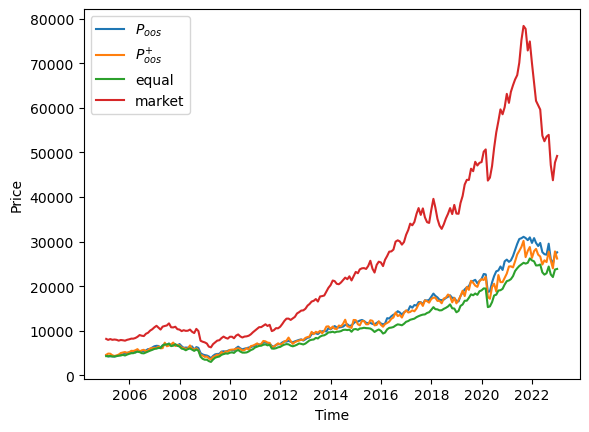

In [22]:
ax = plt.gca()

x = price_df[price_df.index >= '2005'].index
ax.plot(x, price_min_p, label='$P_{oos}$')
ax.plot(x, price_long_only_min_p, label='$P_{oos}^{+}$')
ax.plot(x, price_equal, label='equal')
ax.plot(x, price_mkt, label='market')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# 2. Carbon intensity

## Structure data

In [120]:
err_cols = [i for i in revenue.columns if i.startswith('#')]
revenue = revenue.drop(columns=err_cols)[revenue.index.year == 2021]
revenue.columns = [i.split('-')[0] for i in revenue.columns]

err_cols = [i for i in emission.columns if i.startswith('#')]
emission = emission.drop(columns=err_cols)[emission.index.year == 2021]
emission.columns = [i.split('-')[0] for i in emission.columns]

In [96]:
arr = []
for i in range(len(revenue)):
    a = emission.iloc[i, :].values.reshape(-1, 1) / revenue.iloc[i, :].values.reshape(-1, 1)
    arr.append(a.reshape(-1))
carbon_intensity = pd.DataFrame(arr,
                                columns=[i for i in emission.columns],
                                index=emission.index)
monthly_cols = [i.split('-')[0] for i in monthly_df.columns]
carbon_intensity = carbon_intensity.iloc[:, carbon_intensity.columns.isin(monthly_cols)]
carbon_intensity = carbon_intensity.dropna(axis=1)
carbon_intensity

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.011056,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.334953,0.070085,1.69048,0.245057,0.035129
2021-02-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.011056,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.344994,0.070085,1.69048,0.245057,0.035393
2021-03-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.011056,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.326265,0.070085,1.69048,0.245057,0.034900
2021-04-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.011056,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.317326,0.070085,1.69048,0.245057,0.034665
2021-05-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.007465,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.285697,0.070085,1.69048,0.245057,0.033832
2021-06-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.007465,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.259420,0.070085,1.69048,0.245057,0.033141
2021-07-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.007465,0.007079,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.298395,0.070085,1.69048,0.245057,0.034167
2021-08-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.064594,0.007465,0.011301,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.308670,0.070085,1.69048,0.245057,0.034437
2021-09-01,0.048541,1.106265,0.019325,0.020057,0.022552,0.052447,0.007465,0.011301,0.008928,4.276615,...,0.017795,0.005295,0.001195,0.001594,0.003592,1.321430,0.070085,1.69048,0.245057,0.034773


## 2.1 Carbon intensity 2021 distribution

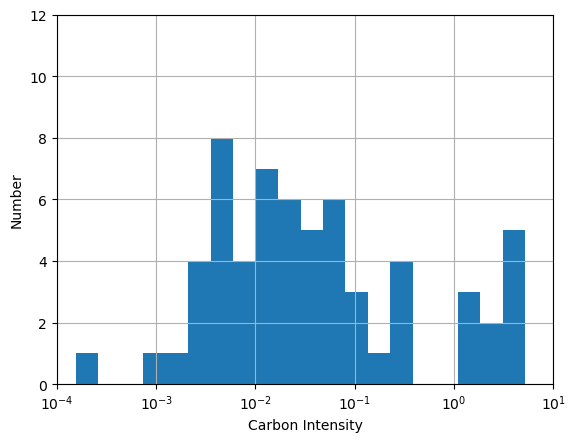

In [97]:
ax = plt.gca()
np.log10(carbon_intensity.mean()).hist(bins=20, ax=ax)
plt.xticks(np.arange(-4, 1.1, 1), ['10$^{%s}$' % i for i in range(-4, 2)])
ax.set_xlabel('Carbon Intensity')
ax.set_ylabel('Number')
ax.set_xlim(-4, 1)
ax.set_ylim(0, 12);

## 2.1 Optimal long-only portfolio with carbon intensity

In [154]:
monthly_carbon = monthly_df
monthly_carbon.columns = [i.split('-')[0] for i in monthly_carbon.columns]
monthly_carbon = monthly_carbon.iloc[:, monthly_carbon.columns.isin(carbon_intensity.columns)]
price_carbon = price_df.iloc[:, price_df.columns.isin(carbon_intensity.columns)]
monthly_carbon

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-31,-0.001698,0.058115,0.050843,-0.137349,0.098276,-5.551115e-16,0.181886,-0.042463,0.067965,-0.087603,...,0.131665,0.019608,-0.042204,0.061350,0.036457,-0.007239,-0.232846,0.075103,0.258427,0.040738
1999-02-28,0.070206,0.121210,-0.109876,-0.092177,0.040220,-3.147608e-02,-0.207552,0.129028,-0.072725,-0.047516,...,0.044231,0.072552,-0.069571,0.016024,-0.042713,0.003408,-0.098919,-0.164418,-0.123305,0.017227
1999-03-31,-0.073479,0.071981,-0.029328,0.064613,0.093340,-1.441489e-01,0.205354,0.185693,-0.086245,-0.034014,...,-0.093600,0.074364,-0.013874,-0.003998,-0.135419,0.024841,0.158523,0.176211,-0.007735,0.044994
1999-04-30,0.105182,0.196200,0.100703,0.197982,0.069682,2.051753e-01,-0.006165,-0.126515,0.126338,0.105473,...,0.022358,0.063830,0.138866,0.013761,0.079269,0.005934,0.178958,-0.052118,0.154346,0.055428
1999-05-31,0.064527,0.096562,-0.043607,-0.037393,-0.141110,6.924152e-02,-0.062737,0.006899,0.031030,0.043197,...,0.190769,-0.128571,0.021916,-0.057378,-0.090397,-0.049073,-0.013410,0.060029,0.003489,-0.023169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.062501,-0.001761,-0.029797,-0.128301,-0.031529,-7.086923e-02,0.011215,-0.065964,-0.093751,0.001805,...,-0.035448,-0.037866,-0.059074,-0.063570,-0.005448,-0.054482,0.056998,0.055286,-0.015338,-0.063061
2022-09-30,-0.172392,-0.147509,-0.198372,-0.098733,-0.087911,-1.386147e-01,-0.142520,-0.110740,-0.131170,-0.131881,...,-0.189555,-0.101097,-0.148976,-0.132971,-0.057937,-0.136721,-0.043765,-0.072215,-0.096505,-0.128258
2022-10-31,0.087673,0.143205,0.118497,0.314017,0.158319,-5.164875e-02,0.128326,0.081015,0.087127,-0.007438,...,0.091597,0.216905,0.124457,0.052071,0.062384,0.020190,0.223025,0.408449,0.082122,0.047584


In [101]:
monthly_carbon_vol = monthly_vol
monthly_carbon_vol.columns = [i.split('-')[0] for i in monthly_carbon_vol.columns]
monthly_carbon_vol = monthly_carbon_vol.iloc[:, monthly_carbon_vol.columns.isin(carbon_intensity.columns)]
monthly_carbon_vol

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-31,0.014673,0.022099,0.034924,0.017742,0.015973,0.031786,0.035565,0.035346,0.021972,0.009142,...,0.031752,0.023403,0.015010,0.025790,0.020131,0.012451,0.058256,0.029576,0.025973,0.009419
1999-02-28,0.020368,0.024412,0.028196,0.023543,0.016189,0.025346,0.064207,0.025223,0.013054,0.010020,...,0.043526,0.022230,0.020777,0.019267,0.020464,0.010717,0.031427,0.025012,0.013483,0.009490
1999-03-31,0.009021,0.030200,0.030676,0.023527,0.013334,0.031529,0.045295,0.039119,0.025886,0.014504,...,0.028602,0.023877,0.012914,0.026188,0.025030,0.006480,0.032164,0.031621,0.018466,0.007083
1999-04-30,0.013431,0.035781,0.029807,0.032410,0.017490,0.054905,0.057425,0.067119,0.013655,0.009136,...,0.038027,0.029681,0.022768,0.021477,0.032488,0.010237,0.030085,0.036449,0.024079,0.009150
1999-05-31,0.011915,0.028292,0.035255,0.025537,0.019569,0.029041,0.046002,0.044745,0.018095,0.013053,...,0.045169,0.025709,0.013220,0.016203,0.026730,0.008164,0.019735,0.030060,0.005926,0.006664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.024069,0.016110,0.024912,0.016334,0.014536,0.024064,0.024275,0.012995,0.016725,0.009216,...,0.015365,0.015746,0.016929,0.016679,0.018894,0.007891,0.036090,0.044627,0.011461,0.009602
2022-09-30,0.021322,0.023163,0.025683,0.023230,0.015993,0.032741,0.012629,0.018808,0.021560,0.018759,...,0.024699,0.020188,0.018556,0.015567,0.021089,0.012364,0.031123,0.046073,0.017421,0.016896
2022-10-31,0.027734,0.019013,0.046206,0.038046,0.017610,0.042602,0.022398,0.019095,0.019808,0.024002,...,0.020134,0.027605,0.018113,0.022053,0.034678,0.017937,0.028008,0.050271,0.010793,0.020740


In [ ]:
win_len = 72  # 6-year moving window
Q = 100  # number of Monte Carlo simulation
m = 2 # number of mean points durung the resampling, here is two for min mean and max mean.
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 16 * 12 # loop index

# --- results --- #
min_mu = []
max_mu = []

min_var = []
max_var = []

min_p = []
max_p = []
# --------------- #

print('Start to generate the portfolio')
while running:
    timestart = time.time()
    
    # generate moving window
    start = c
    stop = c + win_len
    mov = monthly_carbon.iloc[slice(start, stop), :]
    
    # resampling
    mu_res, cov_res, ares, _, _ = portfolio_resampling_pos_constraint(Q=Q, m=m, p0=monthly_carbon)
    min_mu.append(mu_res[0])
    max_mu.append(mu_res[-1])
    
    min_var.append(cov_res[0])
    max_var.append(cov_res[-1])
    
    min_p.append(ares[0])
    max_p.append(ares[-1])
    
    timestop = time.time()
    
    print(f'Progress: {c-16 * 12}/11, {timestop-timestart}s')
    c += 1
    if c == (17 * 12):
        running = False

# Convert to DataFrame        
min_mu = pd.DataFrame(min_mu, index=carbon_intensity.index)
max_mu = pd.DataFrame(max_mu, index=carbon_intensity.index)

min_var = pd.DataFrame(min_var, index=carbon_intensity.index)
max_var = pd.DataFrame(max_var, index=carbon_intensity.index)

min_p = pd.DataFrame(min_p, index=carbon_intensity.index, columns=monthly_carbon.columns)
max_p = pd.DataFrame(max_p, index=carbon_intensity.index, columns=monthly_carbon.columns)

In [103]:
# save
# min_p.to_csv('2.1_Poos_pos_b_min_mu.csv')
# max_p.to_csv('2.1_Poos_pos_b_max_mu.csv')

# read
min_p = pd.read_csv('2.1_Poos_pos_b_min_mu.csv', index_col=0)
max_p = pd.read_csv('2.1_Poos_pos_b_max_mu.csv', index_col=0)

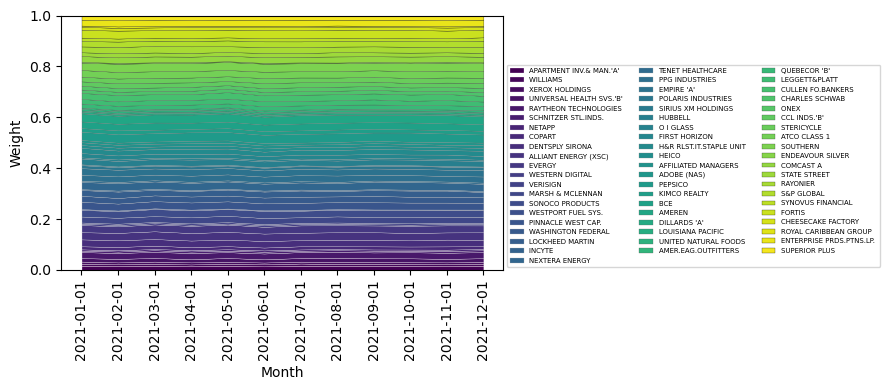

In [178]:
# portfolio distribution over months

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

high = np.zeros(len(min_p))
colors = colormaps['viridis']
edge_colors = colormaps['gray']
for i in range(len(min_p.columns)):
    low = high
    high = low + min_p.iloc[:, i]
    ax.fill_between(x=min_p.index, y1=high, y2=low,
                    color=colors(i/len(min_p.columns)),
                    edgecolor=edge_colors(1 - i/len(min_p.columns)),
                    lw=0.2, label=min_p.columns[i])
ax.legend(ncol=3, fontsize=5, loc=3, bbox_to_anchor=(1, 0))
ax.set_ylim(0, 1)
ax.set_ylabel('Weight')
ax.set_xlabel('Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('poos.pdf')

## 2.2 Carbon footprint

In [129]:
market_cap.columns = [i.split('-')[0] for i in market_cap.columns]
market_cap_2021 = market_cap[market_cap.index.year == 2021]
market_cap_2021 = market_cap_2021.iloc[:, market_cap_2021.columns.isin(carbon_intensity.columns)]
market_cap_2021 = market_cap_2021.resample('M').mean()
market_cap_2021

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-31,723.700952,26249.303333,4401.776667,10350.576667,104736.716190,901.362381,14637.551429,27586.603333,12484.267143,12365.765714,...,228230.809524,26601.539524,4227.383810,76594.888571,5419.210952,18905.140000,1874.645238,16976.253810,47052.495238,1742.414762
2021-02-28,725.423000,27437.999000,4746.703000,10145.307000,110239.665000,930.673000,15200.826500,27251.481000,11890.469000,12084.615000,...,239088.090000,25958.835000,4657.448000,79945.231000,6137.858500,18693.311000,2291.033500,18033.778000,46782.183000,1805.454500
2021-03-31,807.232609,28769.137391,4937.397391,10438.826957,116416.852174,1117.579565,15136.872609,25472.327826,13491.545652,12797.700435,...,254881.452174,28811.815652,4499.780435,83194.431739,6901.563043,19513.267826,2703.950870,22483.535217,49704.368261,1955.613913
2021-04-30,965.515455,28922.818636,4722.159091,11053.470909,119881.504545,1161.119545,16782.400455,28274.549091,14202.035909,13859.270455,...,249747.568182,29060.648182,4904.480455,90491.784091,6866.739545,20653.384545,2727.638636,22072.012727,50051.560000,2064.600000
2021-05-31,1026.257619,31314.270000,4571.447619,12253.030476,129675.780952,1477.807143,17259.480476,29397.035238,14740.311429,14267.969524,...,259238.942857,29910.376190,5220.304762,91834.584286,7168.882381,21289.027619,2751.552381,21766.143810,51407.880000,2202.369048
2021-06-30,1098.485455,33030.501818,4625.052273,12032.915909,132863.295455,1431.037727,18113.757273,30221.940909,14191.565909,14380.205455,...,260198.795455,29209.835455,4966.966818,95092.710909,6926.442273,21482.233636,2591.869545,22875.840000,53483.224545,2220.898636
2021-07-31,1037.845455,31339.119091,4543.038182,11949.555000,129404.740909,1375.940909,17861.344545,33370.693182,13810.004091,14424.749545,...,265631.818182,29065.278636,5171.989545,100039.708636,6298.674545,20911.255000,2450.768182,22293.205455,52215.823182,2175.390000
2021-08-31,1013.054545,29956.462273,4160.980455,11609.111364,129945.518182,1389.975000,18483.210000,33859.120455,13301.669545,15218.521364,...,270568.118182,30825.648182,5178.083182,105660.495455,6287.968636,21585.281818,2294.600000,20148.497727,48585.012273,2123.038182
2021-09-30,1046.480909,30564.497727,3779.345000,11233.290455,127440.877273,1195.729545,20382.077273,34163.240455,13316.184091,14723.955455,...,265699.668182,31402.625455,5231.241364,107553.650000,6090.413182,21429.034545,2394.522273,21520.757273,48309.851364,2022.016818


### CF using $P_{oos}^{(+b)}$

In [131]:
emission = emission.iloc[:, emission.columns.isin(carbon_intensity.columns)]
poos_pos_b = min_p

cf_res = []
for i in range(len(market_cap_2021)):
    o_t = poos_pos_b.iloc[i] / market_cap_2021.iloc[i]
    cf_t = o_t @ emission.iloc[i]
    cf_res.append(cf_t)
cf_res = pd.DataFrame(cf_res, index=carbon_intensity.index, columns=['CF using Poos+b'])
cf_res

,CF using Poos+b
Date,
2021-01-01,372.339507
2021-02-01,396.130053
2021-03-01,376.116980
2021-04-01,352.151499
2021-05-01,328.003004
2021-06-01,324.848668
2021-07-01,343.687164
2021-08-01,335.874331
2021-09-01,339.636116


### Optimize with 75% of CF using  $P_{oos}^{(+b)}$

In [136]:
cf_goal = cf_res * 0.75
cf_goal.columns = ['CF goal']

for i in range(len(cf_goal)):
    goal = cf_goal.iloc[i].values[0]


In [138]:
def optimize_cf(cov, ems, cf, mkt):
    obj = lambda a: a.T @ cov @ a
    cons1 = {
        'type': 'eq',
        'fun': lambda a: a.T @ (np.ones(ems.shape)) - 1
    }
    cons2 = {
        'type': 'eq',
        'fun': lambda a: (a/mkt).T @ ems - cf
    }
    w0 = np.random.random(ems.shape)
    w0 /= w0.sum()
    
    bnds = [[0, None] for i in range(len(w0))]
    res = minimize(obj, x0=w0.reshape(-1), method='SLSQP',
                   constraints=(cons1, cons2), bounds=bnds, options=dict(maxiter=2000))
    return res.x

def resampled_poos_75(Q, ems, p0, cf, mkt, risk_aversion=2, p1_num=200):
    """
    
    :param Q: number of resampleing
    :param m: number of mu
    :param returns: returns
    :param nb_row: number of sample rows
    :param risk_aversion: risk aversion
    """
    mu_0 = p0.mean()
    cov_0 = p0.cov()

    poos_75 = []
    for i in range(Q):
        size = p0.shape
        if p1_num is not None:
            _, col = size
            size = (p1_num, col)
        p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=size)
        p1 = pd.DataFrame(p1)
        p1_ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(
            p1.mean(), p1.cov(), risk_aversion=risk_aversion, num_port=201)
        
        mu_1 = p1.mean()
        cov_1 = p1.cov()
        _poos_75 = optimize_cf(cov_1,ems, cf, mkt)
        poos_75.append(_poos_75)


    poos_75_res = np.asarray(poos_75).sum(axis=0)/Q
    
    return poos_75_res

In [ ]:
win_len = 72  # 6-year moving window
Q = 100  # number of Monte Carlo simulation
p1_num = 200  # number of points of P1 sample, generated from the normal distribution of monthly data.

running = True  # loop condition
c = 16 * 12 # loop index

# --- results --- #
poos_75 = []
# --------------- #

print('Start to generate the portfolio')
i = 0
while running:
    timestart = time.time()
    
    # generate moving window
    start = c
    stop = c + win_len
    mov = monthly_carbon.iloc[slice(start, stop), :]
    
    # resampling
    ems = emission.iloc[i].values
    cf = cf_goal.iloc[i].values[0]
    mkt = market_cap_2021.iloc[i]
    p75 = resampled_poos_75(Q, ems, mov, cf, mkt, risk_aversion=2, p1_num=200)
    poos_75.append(p75)
    timestop = time.time()
    
    print(f'Progress: {c-16 * 12}/11, {timestop-timestart}s')
    c += 1
    i += 1
    if c == (17 * 12):
        running = False

# Convert to DataFrame        
poos_75 = pd.DataFrame(poos_75, index=carbon_intensity.index, columns=monthly_carbon.columns)
poos_75.to_csv('2.2_poos_75.csv')

In [140]:
poos_75 = pd.read_csv('2.2_poos_75.csv', index_col=0)
poos_75

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.019661,0.008385,0.007583,0.018140,0.017139,0.007003,0.009564,0.019665,0.018649,0.026356,...,0.022566,0.014182,0.023895,0.021587,0.012031,0.028152,0.011927,0.004969,0.016269,0.016628
2021-02-01,0.018636,0.009704,0.007612,0.017598,0.018030,0.007248,0.010874,0.019228,0.019692,0.026079,...,0.021813,0.015535,0.021391,0.020560,0.010424,0.027927,0.009495,0.005372,0.015944,0.017840
2021-03-01,0.020533,0.009345,0.007253,0.017016,0.017144,0.007700,0.010144,0.017185,0.019332,0.026855,...,0.024041,0.014378,0.023178,0.022991,0.011297,0.027823,0.010226,0.004974,0.015626,0.017047
2021-04-01,0.017299,0.008994,0.007690,0.018855,0.017644,0.005439,0.010294,0.018185,0.018543,0.024741,...,0.023020,0.014525,0.024538,0.022798,0.010713,0.027609,0.009747,0.005391,0.014980,0.015946
2021-05-01,0.018169,0.008569,0.007961,0.019221,0.016890,0.006268,0.010173,0.018285,0.018109,0.025625,...,0.023180,0.012990,0.022950,0.022886,0.011786,0.029076,0.009976,0.004926,0.015503,0.016930
2021-06-01,0.016527,0.009961,0.008333,0.017750,0.016421,0.006667,0.010809,0.018179,0.018267,0.023851,...,0.022898,0.014998,0.023945,0.022605,0.012621,0.027149,0.009829,0.005011,0.016644,0.017081
2021-07-01,0.017506,0.010218,0.007118,0.017453,0.018478,0.006510,0.011096,0.017689,0.018479,0.025911,...,0.022272,0.014485,0.022912,0.023438,0.010954,0.028532,0.010362,0.004734,0.017089,0.017423
2021-08-01,0.016983,0.009862,0.008298,0.017753,0.017219,0.005586,0.010929,0.018426,0.018207,0.027371,...,0.023523,0.013598,0.022830,0.022235,0.010325,0.028780,0.008868,0.004069,0.016389,0.016025
2021-09-01,0.016454,0.009117,0.007245,0.017698,0.015842,0.005491,0.010045,0.017260,0.018735,0.026227,...,0.022867,0.014431,0.024988,0.023784,0.009641,0.028502,0.009786,0.005078,0.016375,0.016755


Text(0.5, 0, 'Month')

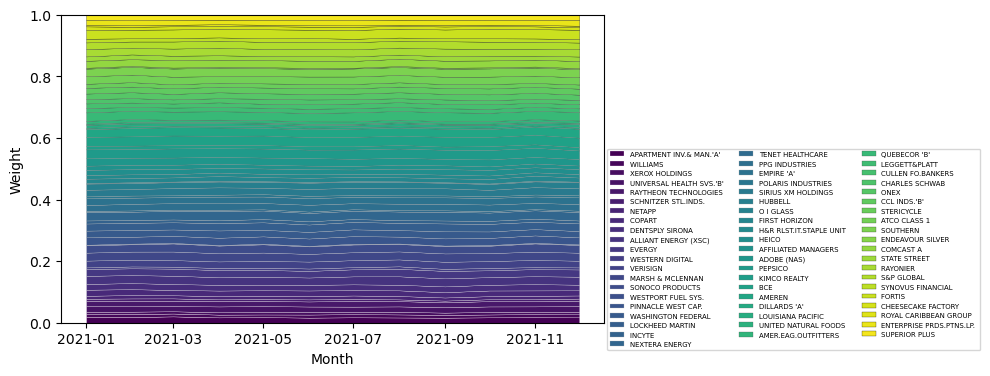

In [141]:
# portfolio distribution over months
poos_75 = pd.read_csv('2.2_poos_75.csv', index_col=0)
poos_75.index = pd.DatetimeIndex(poos_75.index)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

high = np.zeros(len(min_p))
colors = colormaps['viridis']
edge_colors = colormaps['gray']
for i in range(len(poos_75.columns)):
    low = high
    high = low + poos_75.iloc[:, i]
    ax.fill_between(x=poos_75.index, y1=high, y2=low,
                    color=colors(i/len(poos_75.columns)),
                    edgecolor=edge_colors(1 - i/len(poos_75.columns)),
                    lw=0.2, label=poos_75.columns[i])
ax.legend(ncol=3, fontsize=5, loc=3, bbox_to_anchor=(1, -0.1))
ax.set_ylim(0, 1)
ax.set_ylabel('Weight')
ax.set_xlabel('Month')
plt.tight_layout()
plt.savefig('poos.pdf')

In [142]:
y = r[r.index.year == 2021]
y.columns = [i.split('-')[0] for i in y.columns]
y = y.iloc[:, y.columns.isin(carbon_intensity.columns)]
y[y.index.month == 1].cov()

,APARTMENT INV.& MAN.'A',WILLIAMS,XEROX HOLDINGS,UNIVERSAL HEALTH SVS.'B',RAYTHEON TECHNOLOGIES,SCHNITZER STL.INDS.,NETAPP,COPART,DENTSPLY SIRONA,ALLIANT ENERGY (XSC),...,COMCAST A,STATE STREET,RAYONIER,S&P GLOBAL,SYNOVUS FINANCIAL,FORTIS,CHEESECAKE FACTORY,ROYAL CARIBBEAN GROUP,ENTERPRISE PRDS.PTNS.LP.,SUPERIOR PLUS
APARTMENT INV.& MAN.'A',0.000237,0.000057,0.000075,8.411737e-05,0.000167,0.000114,-4.144886e-05,0.000041,0.000025,0.000122,...,0.000212,0.000117,0.000105,0.000031,0.000159,0.000041,-9.396564e-05,0.000232,0.000095,0.000016
WILLIAMS,0.000057,0.000323,0.000059,1.617639e-04,0.000182,0.000363,2.318039e-05,0.000019,0.000254,-0.000010,...,-0.000003,0.000335,0.000158,0.000005,0.000386,0.000013,3.314632e-05,0.000196,0.000298,0.000151
XEROX HOLDINGS,0.000075,0.000059,0.000370,1.567605e-04,0.000169,0.000216,5.191835e-05,0.000085,0.000061,-0.000057,...,0.000183,0.000097,0.000047,-0.000038,0.000181,0.000010,-7.882218e-05,0.000216,0.000113,0.000066
UNIVERSAL HEALTH SVS.'B',0.000084,0.000162,0.000157,3.096111e-04,0.000184,0.000340,-7.191006e-07,0.000077,0.000196,0.000056,...,0.000154,0.000238,0.000173,0.000128,0.000316,0.000050,9.198863e-07,0.000170,0.000188,0.000094
RAYTHEON TECHNOLOGIES,0.000167,0.000182,0.000169,1.839422e-04,0.000353,0.000228,-6.746651e-06,0.000163,0.000140,0.000010,...,0.000283,0.000307,0.000123,0.000100,0.000367,0.000025,-1.778025e-04,0.000365,0.000263,0.000135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FORTIS,0.000041,0.000013,0.000010,4.992404e-05,0.000025,-0.000077,-6.129399e-05,-0.000016,0.000041,0.000052,...,0.000037,0.000045,0.000032,0.000064,0.000060,0.000089,-3.002674e-05,-0.000030,0.000031,0.000003
CHEESECAKE FACTORY,-0.000094,0.000033,-0.000079,9.198863e-07,-0.000178,-0.000365,4.059357e-04,-0.000094,-0.000021,0.000082,...,-0.000319,-0.000113,0.000001,-0.000349,-0.000198,-0.000030,1.431092e-03,-0.000256,0.000026,0.000007
ROYAL CARIBBEAN GROUP,0.000232,0.000196,0.000216,1.704338e-04,0.000365,0.000343,8.492359e-05,0.000231,0.000084,-0.000098,...,0.000284,0.000292,0.000154,0.000010,0.000404,-0.000030,-2.559557e-04,0.000821,0.000308,0.000160
ENTERPRISE PRDS.PTNS.LP.,0.000095,0.000298,0.000113,1.882818e-04,0.000263,0.000398,-2.682870e-05,0.000071,0.000285,0.000001,...,0.000135,0.000416,0.000186,0.000031,0.000515,0.000031,2.582490e-05,0.000308,0.000493,0.000208


#### Comparison of return

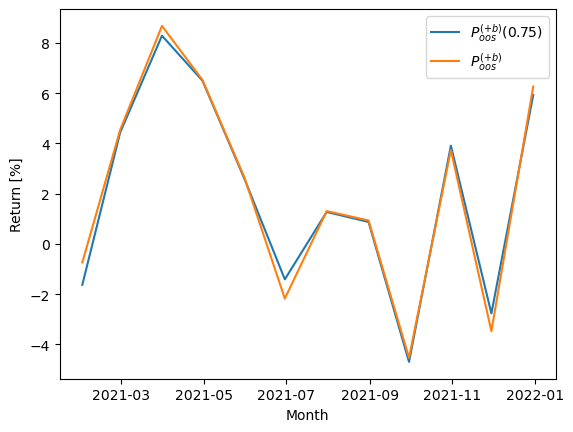

In [143]:
poos_75 = pd.read_csv('2.2_poos_75.csv', index_col=0)
poos = pd.read_csv('2.1_Poos_pos_b_min_mu.csv', index_col=0)

ax = plt.gca()

ret_75_mu = []
ret_mu = []

for i in range(12):
    mu = monthly_carbon[monthly_carbon.index.year == 2021].iloc[i]
    ret_75_mu.append(poos_75.iloc[i] @ mu.T * 100)
    ret_mu.append(poos.iloc[i] @ mu.T * 100)
x = monthly_carbon[monthly_carbon.index.year == 2021].index
ax.plot(x, ret_75_mu, label='$P_{oos}^{(+b)}(0.75)$')
ax.plot(x, ret_mu, label='$P_{oos}^{(+b)}$')
ax.set_xlabel('Month')
ax.set_ylabel('Return [%]')
ax.legend()

#### Comparison of volatility

Text(0, 0.5, 'Volatility')

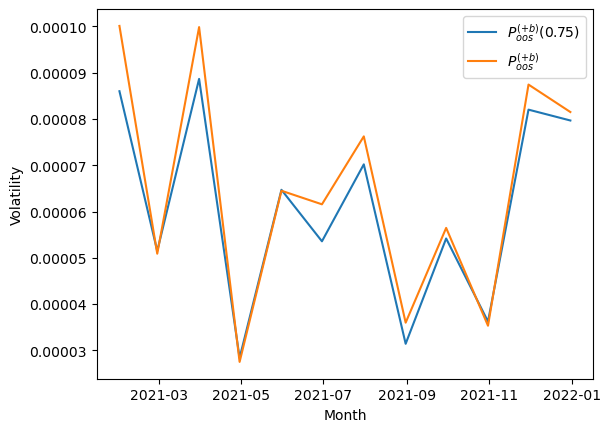

In [144]:
poos_75 = pd.read_csv('2.2_poos_75.csv', index_col=0)
poos = pd.read_csv('2.1_Poos_pos_b_min_mu.csv', index_col=0)

ax = plt.gca()

ret_75_vol = []
ret_vol = []

# daily return for calculating the monthly sigma
y = r[r.index.year == 2021]
y.columns = [i.split('-')[0] for i in y.columns]
y = y.iloc[:, y.columns.isin(carbon_intensity.columns)]
for i in range(12):
    sigma = y[y.index.month == (i+1)].cov()
    ret_75_vol.append(poos_75.iloc[i] @ sigma @ poos_75.iloc[i])
    ret_vol.append(poos.iloc[i] @ sigma @ poos.iloc[i])
x = monthly_carbon[monthly_carbon.index.year == 2021].index
ax.plot(x, ret_75_vol, label='$P_{oos}^{(+b)}(0.75)$')
ax.plot(x, ret_vol, label='$P_{oos}^{(+b)}$')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Volatility')

In [145]:
comp = {
    'annualized_return': [np.mean(ret_mu) * 12, np.mean(ret_75_mu) * 12],
    'annualized_vol': [np.sqrt(12)*np.mean(ret_vol), np.sqrt(12)*np.mean(ret_75_vol)]
}
pd.DataFrame(comp, index=['Poos_+b', 'Poos_+b(0.75)'])

,annualized_return,annualized_vol
Poos_+b,23.726479,0.000224
Poos_+b(0.75),23.325288,0.000210


In [165]:

poos_returns = poos.values * monthly_carbon[monthly_carbon.index.year == 2021].values
poos_price = poos.values * price_carbon[price_carbon.index.year == 2021].values

poos_75_returns = poos_75.values * monthly_carbon[monthly_carbon.index.year == 2021].values
poos_75_price = poos_75.values * price_carbon[price_carbon.index.year == 2021].values

In [171]:
poos_char = cal_char(pd.DataFrame(poos_returns), poos_price)
poos_75_char = cal_char(pd.DataFrame(poos_75_returns), poos_75_price)

char_sum = pd.concat([pd.DataFrame(poos_char._asdict(), index=['poos']),
                      pd.DataFrame(poos_75_char._asdict(), index=['poos_75'])])
char_sum

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


,annualized_average_return,annualized_volatility,minimal,maximal,max_drawdown,VaR,ES
poos,0.007268,0.006026,-0.002127,0.004884,-0.999958,-0.001369,-0.002127
poos_75,0.008427,0.007223,-0.002569,0.005953,-0.999972,-0.001595,-0.002569


In [164]:
poos.values * monthly_carbon[monthly_carbon.index.year == 2021].values

array([[-2.12737075e-03,  4.82825782e-04, -7.95852178e-04,
        -1.26006919e-03, -1.58382019e-03, -4.21099100e-04,
         4.88843558e-05, -1.65471392e-03,  5.86291094e-04,
        -1.36434558e-03, -8.99257913e-04,  9.84893269e-05,
        -4.94738107e-04, -1.32439724e-03, -5.85633424e-04,
         1.28974467e-03, -1.38744439e-03,  4.05927503e-04,
        -2.09657498e-03,  1.13647310e-04,  1.34950039e-03,
         8.85335429e-04, -1.54755946e-03,  4.30980521e-04,
         2.65539192e-03, -5.77580014e-05, -1.72697859e-04,
         2.91875451e-04,  1.49050270e-03, -1.69917793e-03,
        -1.23509983e-03,  8.99997612e-04, -7.47720566e-04,
        -2.55575034e-03,  1.42524664e-03, -1.63341319e-04,
        -2.16836657e-03,  2.64909100e-03,  1.04830658e-04,
         4.25569792e-03,  6.81753742e-04, -1.07939279e-03,
        -1.35680370e-03,  1.34412958e-03, -3.79668609e-04,
        -1.10162347e-03,  2.14805211e-04, -1.01425351e-03,
         1.53135584e-05, -1.16667196e-03, -5.29214794e-0

In [172]:
char_sum.to_latex

<bound method NDFrame.to_latex of          annualized_average_return  annualized_volatility   minimal   maximal  \
poos                      0.007268               0.006026 -0.002127  0.004884   
poos_75                   0.008427               0.007223 -0.002569  0.005953   

         max_drawdown       VaR        ES  
poos        -0.999958 -0.001369 -0.002127  
poos_75     -0.999972 -0.001595 -0.002569  >